In [1]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
from salishsea_tools import geo_tools, nc_tools, tidetools, viz_tools
import xarray as xr
import datetime
import pandas as pd
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

%matplotlib inline

In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [5]:
grid = nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc')
ferry_data = 'https://salishsea.eos.ubc.ca/erddap/tabledap/ubcONCTWDP1mV18-01'
nowcast_data = 'https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSg3DBiologyFields1hV17-02'
bathy, X, Y = tidetools.get_bathy_data(grid)
ferry = nc.Dataset(ferry_data)
nowcast = xr.open_dataset(nowcast_data)

In [117]:
plt.style.use('/ocean/vdo/MEOPAR/biomodelevalpaper/bioModelEvalPaper.mplstyle')

In [26]:
ferry = pd.read_csv('https://salishsea.eos.ubc.ca/erddap/tabledap/ubcONCTWDP1mV18-01.csv?time%2Clongitude%2Clatitude%2Cchlorophyll&time%3E=2014-09-13T00%3A00%3A00Z&time%3C=2018-01-08T23%3A59%3A00Z')
ferry = ferry.drop(ferry.index[0])

/home/vdo/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (1,2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [22]:
nc.num2date(ferry.variables['s.time'][1101000], ferry.variables['s.time'].units)

datetime.datetime(2014, 9, 12, 10, 39)

In [23]:
nc.num2date(ferry.variables['s.time'][-1], ferry.variables['s.time'].units)

datetime.datetime(2018, 1, 9, 23, 59)

In [10]:
import pickle

In [11]:
HINDCAST_PATH= '/results/SalishSea/nowcast-green/'

In [12]:
import os

In [47]:
ferry = ferry.dropna()

In [74]:
list_of_model_chl = np.array([])
list_of_ferry_chl = np.array([])
list_of_lons = np.array([])
#unit = ferry.variables['s.time'].units
for n in ferry.index: #2563687):
    #if ((ferry.variables['s.latitude'][n].mask == False) 
        #and (ferry.variables['s.chlorophyll'][n].mask == False)):
    Yind, Xind = geo_tools.find_closest_model_point(float(ferry.longitude[n]), 
                                                    float(ferry.latitude[n]), 
                                                    X, Y, land_mask = bathy.mask)
    date = datetime.datetime.strptime(ferry.time[n][:-1], '%Y-%m-%dT%H:%M:%S')
    sub_dir = date.strftime('%d%b%y').lower()
    datestr = date.strftime('%Y%m%d')
    fname = 'SalishSea_1h_{}_{}_ptrc_T.nc'.format(datestr, datestr)
    nuts = nc.Dataset(os.path.join(HINDCAST_PATH, sub_dir, fname))
    if date.minute < 30:
        before = datetime.datetime(year = date.year, month = date.month, day = date.day, 
                           hour = (date.hour), minute = 30) - datetime.timedelta(hours=1)
        after = before + datetime.timedelta(hours=1)
        sub_dir2 = after.strftime('%d%b%y').lower()
        datestr2 = after.strftime('%Y%m%d')
        fname2 = 'SalishSea_1h_{}_{}_ptrc_T.nc'.format(datestr2, datestr2)
        nuts2 = nc.Dataset(os.path.join(HINDCAST_PATH, sub_dir2, fname2))
        delta = (date - before).seconds / 3600
        chl_val = 1.6*((1-delta)*(nuts.variables['diatoms'][before.hour, 1, Yind, Xind] 
                       + nuts.variables['ciliates'][before.hour,1,Yind, Xind] 
                       + nuts.variables['flagellates'][before.hour,1,Yind,Xind]) + 
                   (delta)*(nuts2.variables['diatoms'][after.hour, 1, Yind, Xind] 
                       + nuts2.variables['ciliates'][after.hour,1,Yind, Xind] 
                       + nuts2.variables['flagellates'][after.hour,1,Yind,Xind]))
    if date.minute >= 30:
        before = datetime.datetime(year = date.year, month = date.month, day = date.day, 
                               hour = (date.hour), minute = 30)
        after = before + datetime.timedelta(hours=1)
        sub_dir2 = after.strftime('%d%b%y').lower()
        datestr2 = after.strftime('%Y%m%d')
        fname2 = 'SalishSea_1h_{}_{}_ptrc_T.nc'.format(datestr2, datestr2)
        nuts2 = nc.Dataset(os.path.join(HINDCAST_PATH, sub_dir2, fname2))
        delta = (date - before).seconds / 3600
        chl_val = 1.6*((1-delta)*(nuts.variables['diatoms'][before.hour, 1, Yind, Xind] 
                       + nuts.variables['ciliates'][before.hour,1,Yind, Xind] 
                       + nuts.variables['flagellates'][before.hour,1,Yind,Xind]) + 
                   (delta)*(nuts.variables['diatoms'][after.hour, 1, Yind, Xind] 
                       + nuts.variables['ciliates'][after.hour,1,Yind, Xind] 
                       + nuts.variables['flagellates'][after.hour,1,Yind,Xind]))
    list_of_ferry_chl = np.append(list_of_ferry_chl, float(ferry.chlorophyll[n]))
    list_of_model_chl = np.append(list_of_model_chl, chl_val)
    list_of_lons = np.append(list_of_lons, float(ferry.longitude[n]))

In [75]:
list_of_lons.shape

(689721,)

In [76]:
list_of_model_chl.shape

(689721,)

In [77]:
bounds = pickle.load(open('bounds.pkl', 'rb'))

In [78]:
def make_plot(n):
    fig, ax = plt.subplots(figsize = (10,10))
    c, xedge, yedge, im = ax.hist2d(list_of_ferry_chl[(bounds[n]<=list_of_lons) 
                                                       &  (list_of_lons< bounds[n+1])], 
                                    list_of_model_chl[(bounds[n]<=list_of_lons) 
                                                       &  (list_of_lons< bounds[n+1])], 
                                    bins = 100, norm=LogNorm())
    fig.colorbar(im, ax=ax)
    ax.set_xlabel('Ferry Data')
    ax.set_ylabel('Nowcast-green')
    ax.plot(np.arange(0,35), 'r-')
    ax.set_title(str(bounds[n]) + ' < lon < ' + str(bounds[n+1]))
    print('bias =  ' + str(-np.mean(list_of_ferry_chl[(bounds[n]<=list_of_lons) 
                                                       & (list_of_lons< bounds[n+1])]) + 
                           np.mean(list_of_model_chl[(bounds[n]<=list_of_lons) 
                                                      & (list_of_lons< bounds[n+1])])))
    print('RMSE = ' + str(np.sqrt(np.sum((list_of_model_chl[(bounds[n]<=list_of_lons) 
                                                             &  (list_of_lons< bounds[n+1])] - 
                                          list_of_ferry_chl[(bounds[n]<=list_of_lons) 
                                                             & (list_of_lons< bounds[n+1])])**2) 
                                  / len(list_of_model_chl[(bounds[n]<=list_of_lons) 
                                                           &  (list_of_lons< bounds[n+1])]))))
    xbar = np.mean(list_of_ferry_chl[(bounds[n]<=list_of_lons) &  (list_of_lons< bounds[n+1])])
    print('Willmott = ' + str(1-(np.sum((list_of_model_chl[(bounds[n]<=list_of_lons) 
                                                            & (list_of_lons< bounds[n+1])] - 
                                         list_of_ferry_chl[(bounds[n]<=list_of_lons) 
                                                            &  (list_of_lons< bounds[n+1])])**2)  / 
                                 np.sum((np.abs(list_of_model_chl[(bounds[n]<=list_of_lons) 
                                                                   &  (list_of_lons< bounds[n+1])] 
                                                - xbar) 
                                         + np.abs(list_of_ferry_chl[(bounds[n]<=list_of_lons) 
                                                                     &  (list_of_lons< bounds[n+1])] 
                                                  - xbar))**2))))

In [105]:
def make_log_plot(n):
    fig, ax = plt.subplots(figsize = (10,10))
    c, xedge, yedge, im = ax.hist2d(list_of_ferry_chl2[(bounds[n]<=list_of_lons2) 
                                                       &  (list_of_lons2< bounds[n+1])], 
                                    list_of_model_chl2[(bounds[n]<=list_of_lons2) 
                                                       &  (list_of_lons2< bounds[n+1])], 
                                    bins = 100, norm=LogNorm())
    fig.colorbar(im, ax=ax)
    ax.set_xlabel('Ferry Data')
    ax.set_ylabel('Nowcast-green')
    ax.plot(np.arange(0,35), 'r-')
    ax.set_title(str(bounds[n]) + ' < lon < ' + str(bounds[n+1]))
    print('bias =  ' + str(-np.mean(list_of_ferry_chl2[(bounds[n]<=list_of_lons2) 
                                                       & (list_of_lons2< bounds[n+1])]) + 
                           np.mean(list_of_model_chl2[(bounds[n]<=list_of_lons2) 
                                                      & (list_of_lons2< bounds[n+1])])))
    print('RMSE = ' + str(np.sqrt(np.sum((list_of_model_chl2[(bounds[n]<=list_of_lons2) 
                                                             &  (list_of_lons2< bounds[n+1])] - 
                                          list_of_ferry_chl2[(bounds[n]<=list_of_lons2) 
                                                             & (list_of_lons2< bounds[n+1])])**2) 
                                  / len(list_of_model_chl2[(bounds[n]<=list_of_lons2) 
                                                           &  (list_of_lons2< bounds[n+1])]))))
    xbar = np.mean(list_of_ferry_chl2[(bounds[n]<=list_of_lons2) &  (list_of_lons2< bounds[n+1])])
    print('Willmott = ' + str(1-(np.sum((list_of_model_chl2[(bounds[n]<=list_of_lons2) 
                                                            & (list_of_lons2< bounds[n+1])] - 
                                         list_of_ferry_chl2[(bounds[n]<=list_of_lons2) 
                                                            &  (list_of_lons2< bounds[n+1])])**2)  / 
                                 np.sum((np.abs(list_of_model_chl2[(bounds[n]<=list_of_lons2) 
                                                                   &  (list_of_lons2< bounds[n+1])] 
                                                - xbar) 
                                         + np.abs(list_of_ferry_chl2[(bounds[n]<=list_of_lons2) 
                                                                     &  (list_of_lons2< bounds[n+1])] 
                                                  - xbar))**2))))

In [67]:
output = open('ferry_chl.pkl', 'wb')
pickle.dump(list_of_ferry_chl, output)
output.close()
output = open('model_chl.pkl', 'wb')
pickle.dump(list_of_model_chl, output)
output.close()
output = open('chl_lons.pkl', 'wb')
pickle.dump(list_of_lons, output)
output.close()

In [4]:
list_of_model_chl = pickle.load(open('model_chl.pkl', 'rb'))
list_of_ferry_chl = pickle.load(open('ferry_chl.pkl', 'rb'))

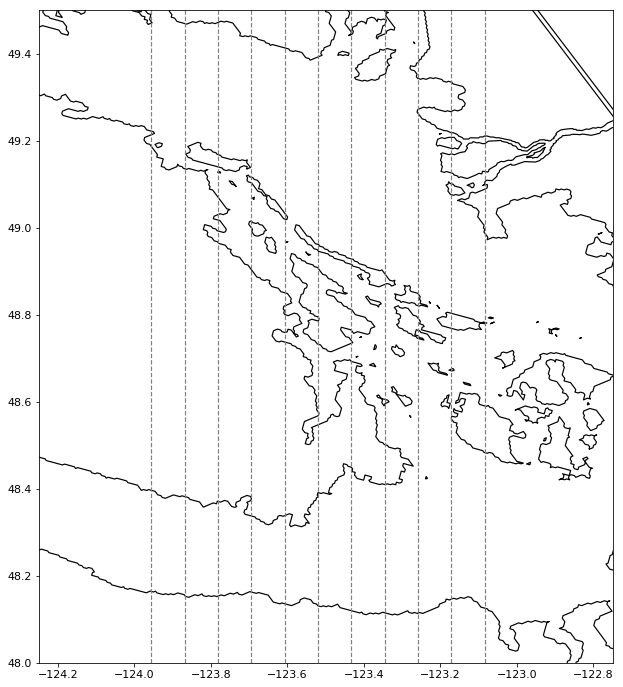

In [118]:
fig, ax = plt.subplots(figsize = (12,12))
viz_tools.plot_coastline(ax, grid, coords = 'map')
viz_tools.set_aspect(ax, coords = 'map')
ax.set_xlim(-124.25, -122.75)
ax.set_ylim(48, 49.5)
for p in range(11):
    ax.plot((bounds[p], bounds[p]), (48, 49.5), '--', color = 'grey')

In [55]:
from matplotlib.colors import LogNorm

In [82]:
list_of_model_chl = list_of_model_chl[list_of_ferry_chl < 25]
list_of_lons = list_of_lons[list_of_ferry_chl < 25]
list_of_ferry_chl = list_of_ferry_chl[list_of_ferry_chl < 25]

bias =  2.24150135282
RMSE = 4.35246068562
Willmott = 0.529002882478


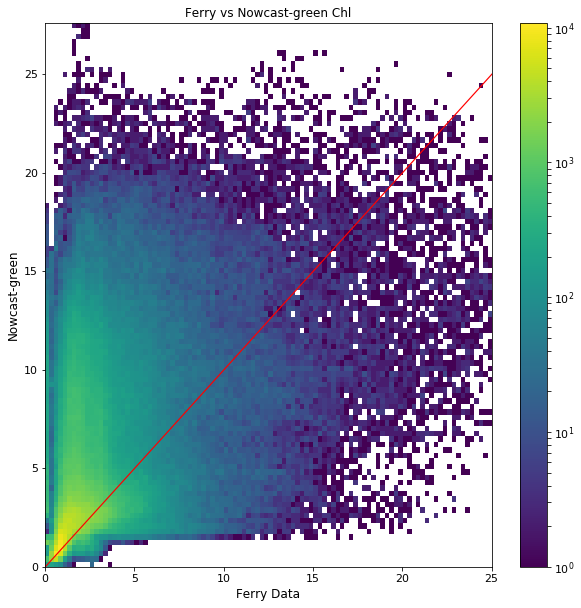

In [119]:
fig, ax = plt.subplots(figsize = (10,10))
c, xedge, yedge, im = ax.hist2d(list_of_ferry_chl, list_of_model_chl, 
                                bins = 100, norm=LogNorm())
fig.colorbar(im, ax=ax)
ax.set_xlabel('Ferry Data')
ax.set_ylabel('Nowcast-green')
ax.plot(np.arange(0,35), 'r-')
ax.set_title('Ferry vs Nowcast-green Chl')
print('bias =  ' + str(-np.mean(list_of_ferry_chl) + np.mean(list_of_model_chl)))
print('RMSE = ' + str(np.sqrt(np.sum((list_of_model_chl - list_of_ferry_chl)**2) 
                              / len(list_of_model_chl))))
xbar = np.mean(list_of_ferry_chl)
print('Willmott = ' + str(1-(np.sum((list_of_model_chl - list_of_ferry_chl)**2)  / 
                             np.sum((np.abs(list_of_model_chl - xbar) 
                                     + np.abs(list_of_ferry_chl - xbar))**2))))

bias =  0.902179383818
RMSE = 3.20718067316
Willmott = 0.606096675921


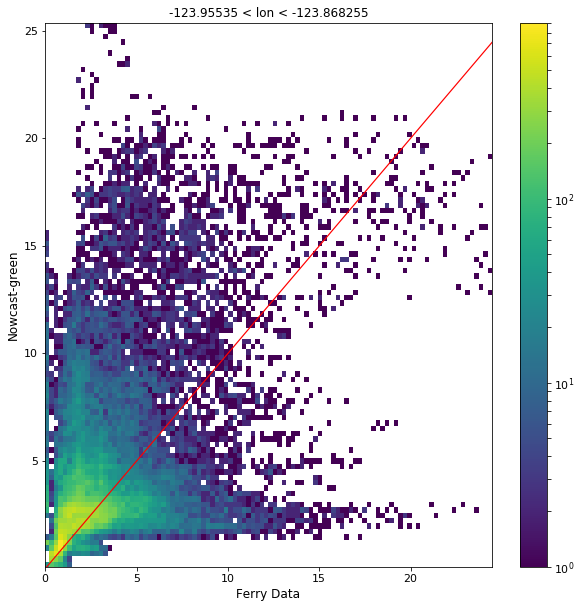

In [120]:
make_plot(0)

bias =  0.933970984698
RMSE = 2.90742581711
Willmott = 0.661740900677


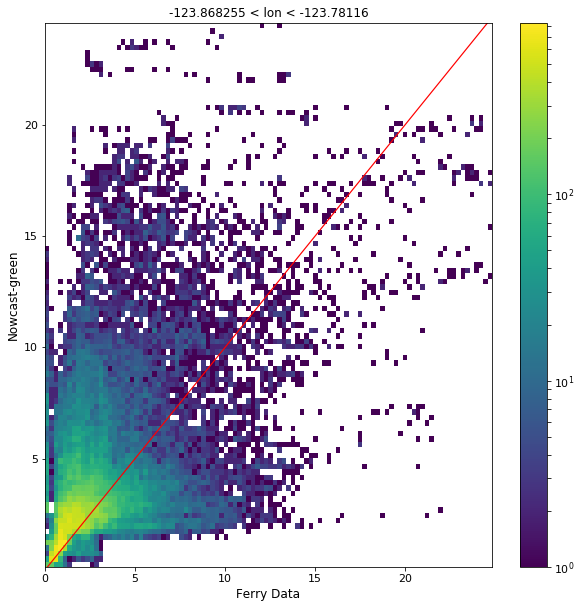

In [121]:
make_plot(1)

bias =  1.03479817565
RMSE = 2.93972492984
Willmott = 0.677210364228


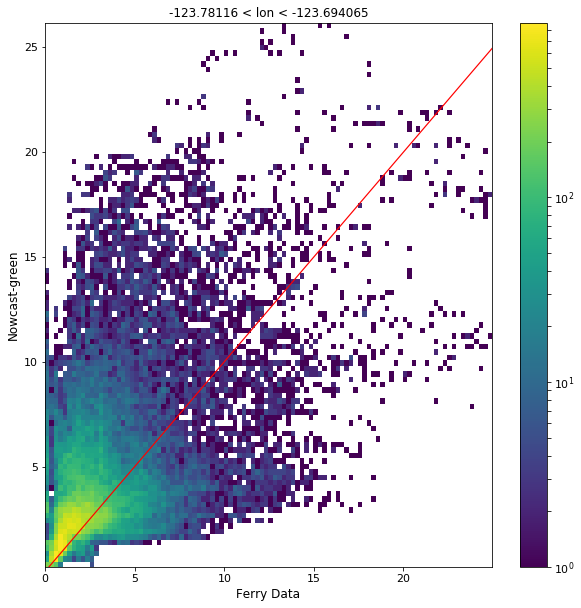

In [122]:
make_plot(2)

bias =  1.04543188284
RMSE = 3.11514260522
Willmott = 0.669705472444


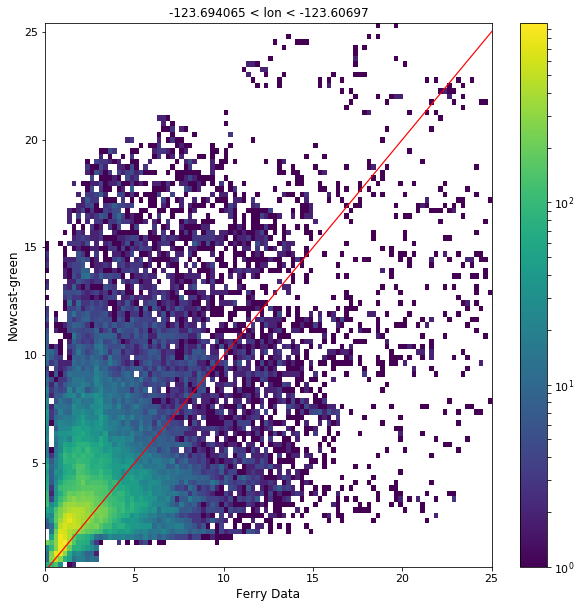

In [123]:
make_plot(3)

bias =  1.34125867632
RMSE = 3.44261966813
Willmott = 0.627474238704


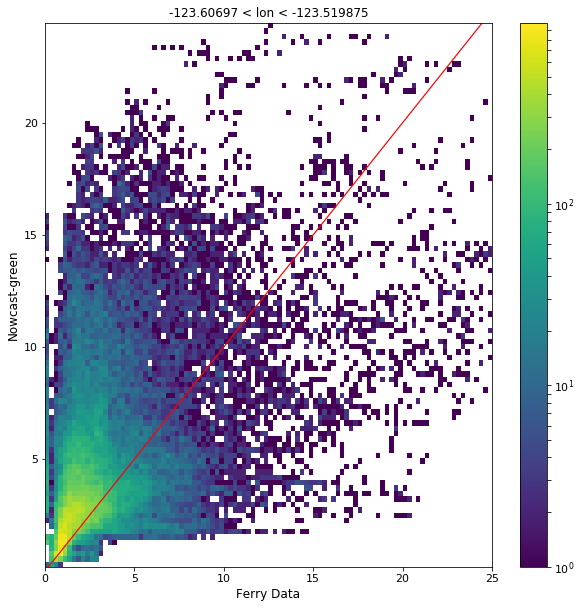

In [124]:
make_plot(4)

bias =  1.97928911311
RMSE = 3.9096394528
Willmott = 0.576622408505


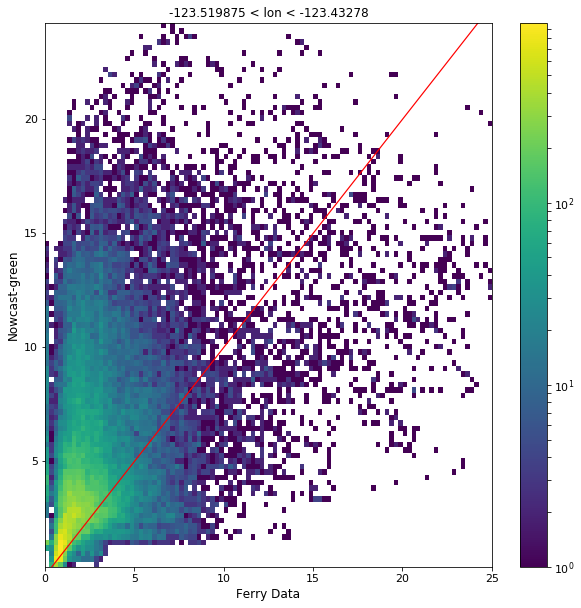

In [125]:
make_plot(5)

bias =  2.87605659987
RMSE = 4.66549772898
Willmott = 0.481705152104


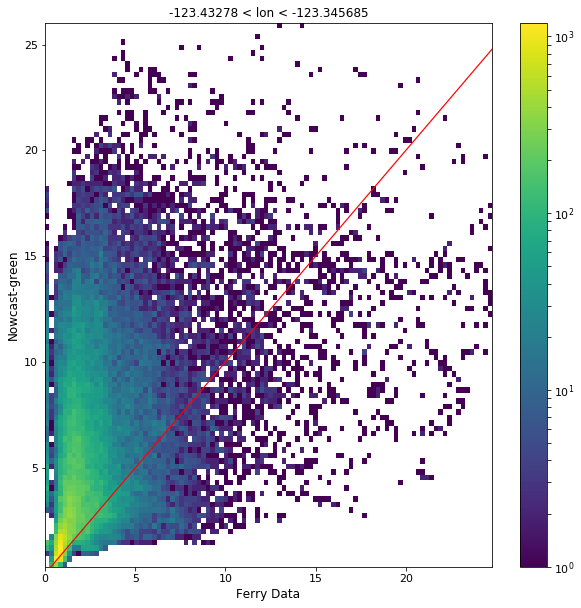

In [126]:
make_plot(6)

bias =  3.8895618077
RMSE = 5.59300833118
Willmott = 0.459957502523


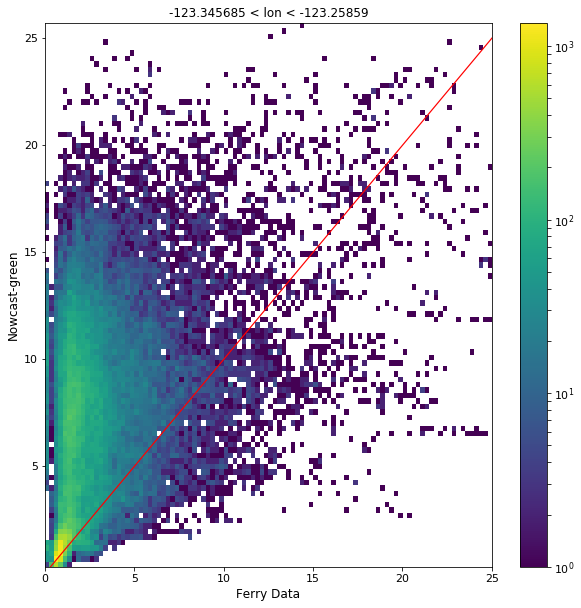

In [127]:
make_plot(7)

bias =  4.56881378995
RMSE = 6.28284028573
Willmott = 0.427640182739


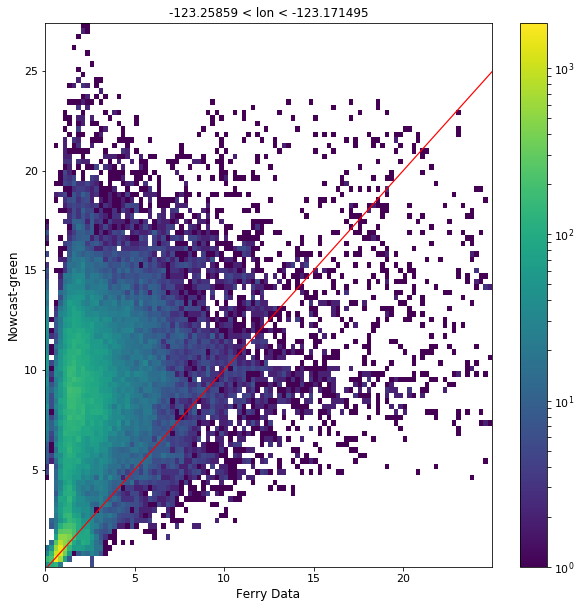

In [128]:
make_plot(8)

bias =  4.7003581558
RMSE = 6.43318200031
Willmott = 0.410616257023


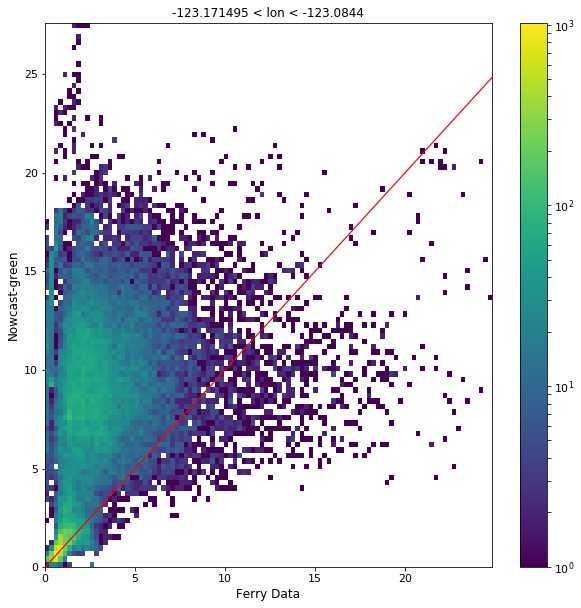

In [129]:
make_plot(9)

# Log(Chl)

In [103]:
list_of_ferry_chl2 = np.log10(list_of_ferry_chl[list_of_ferry_chl > 0])
list_of_model_chl2 = np.log10(list_of_model_chl[list_of_ferry_chl > 0])
list_of_lons2 = list_of_lons[list_of_ferry_chl > 0]

bias =  0.276789093701
RMSE = 0.488470893877
Willmott = 0.59731963709


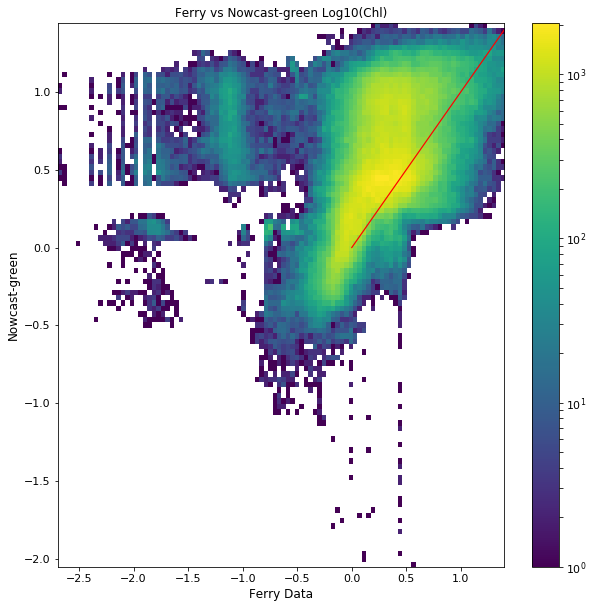

In [130]:
fig, ax = plt.subplots(figsize = (10,10))
c, xedge, yedge, im = ax.hist2d(list_of_ferry_chl2, list_of_model_chl2, 
                                bins = 100, norm=LogNorm())
fig.colorbar(im, ax=ax)
ax.set_xlabel('Ferry Data')
ax.set_ylabel('Nowcast-green')
ax.plot(np.arange(0,35), 'r-')
ax.set_title('Ferry vs Nowcast-green Log10(Chl)')
print('bias =  ' + str(-np.mean(list_of_ferry_chl2) + np.mean(list_of_model_chl2)))
print('RMSE = ' + str(np.sqrt(np.sum((list_of_model_chl2 - list_of_ferry_chl2)**2) 
                              / len(list_of_model_chl2))))
xbar = np.mean(list_of_ferry_chl2)
print('Willmott = ' + str(1-(np.sum((list_of_model_chl2 - list_of_ferry_chl2)**2)  / 
                             np.sum((np.abs(list_of_model_chl2 - xbar) 
                                     + np.abs(list_of_ferry_chl2 - xbar))**2))))

bias =  0.155784823359
RMSE = 0.415451828182
Willmott = 0.625474931503


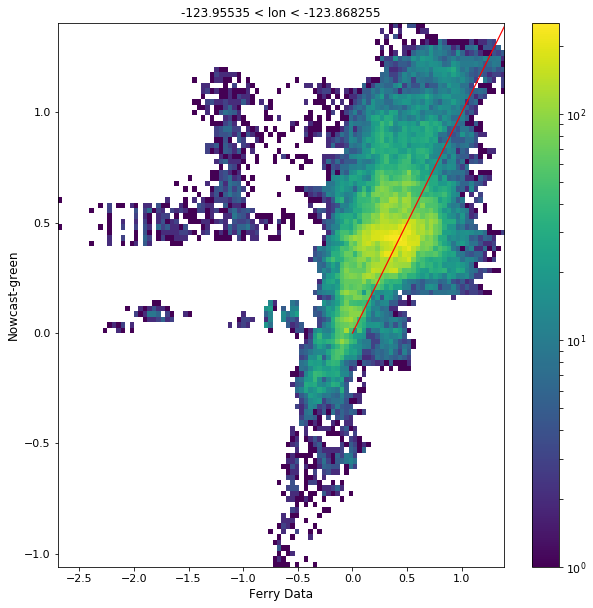

In [131]:
make_log_plot(0)

bias =  0.177037448984
RMSE = 0.4105186654
Willmott = 0.649335129276


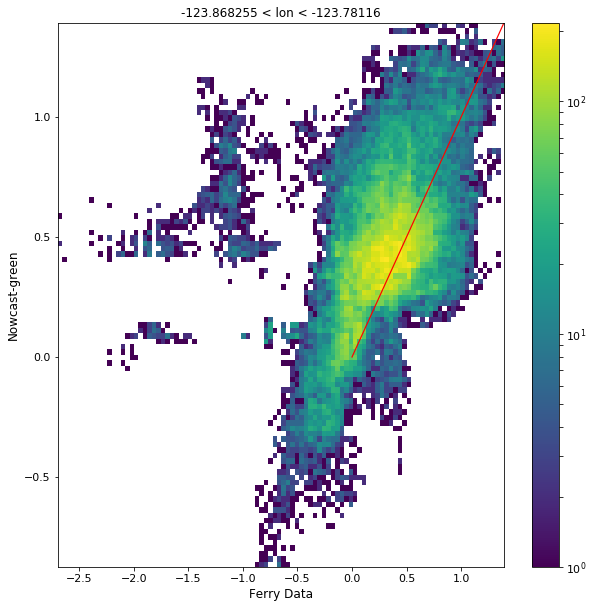

In [132]:
make_log_plot(1)

bias =  0.192543155155
RMSE = 0.414532481919
Willmott = 0.654179032163


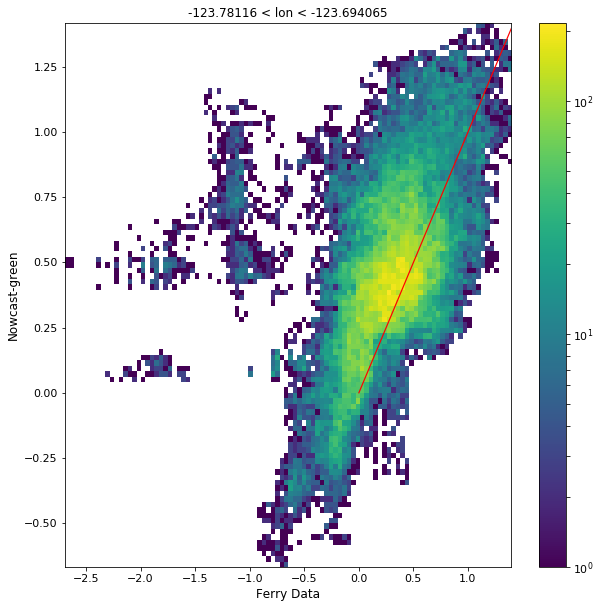

In [133]:
make_log_plot(2)

bias =  0.182110031396
RMSE = 0.41138795573
Willmott = 0.64124886339


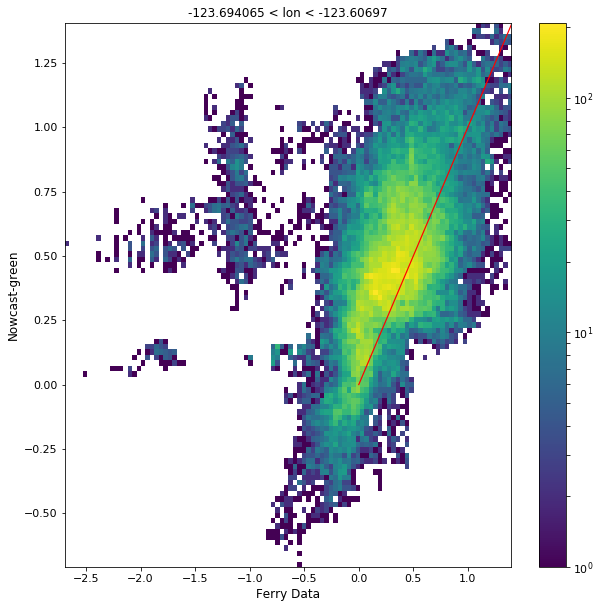

In [134]:
make_log_plot(3)

bias =  0.208933057461
RMSE = 0.427668640963
Willmott = 0.61568651551


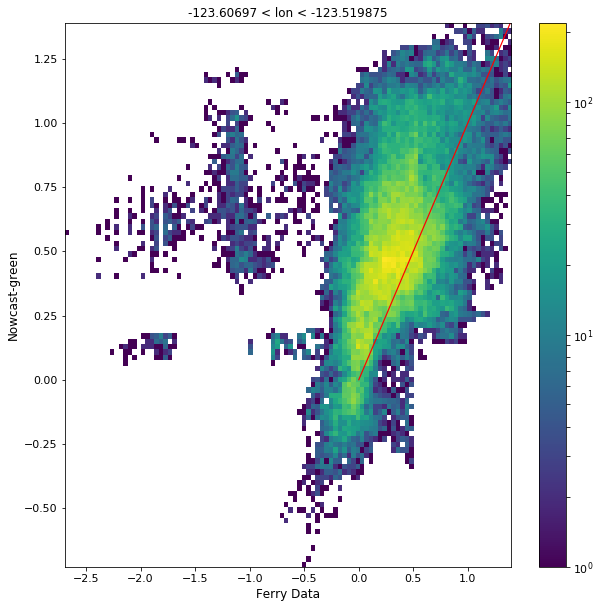

In [135]:
make_log_plot(4)

bias =  0.262591227611
RMSE = 0.457785048644
Willmott = 0.598083087025


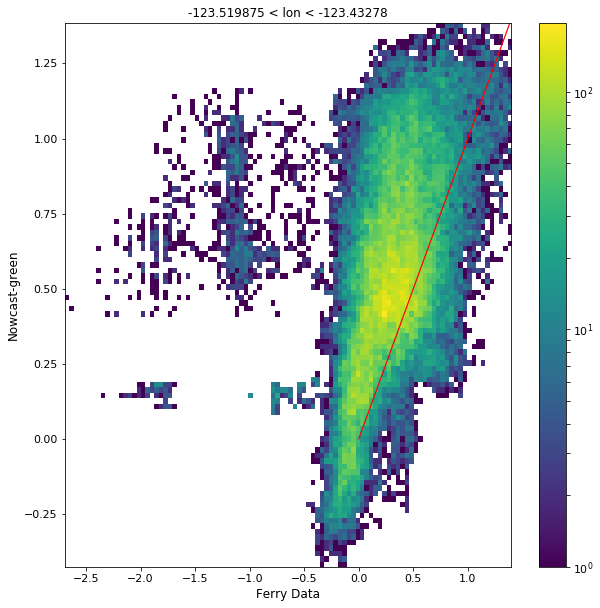

In [136]:
make_log_plot(5)

bias =  0.349369067258
RMSE = 0.524244637082
Willmott = 0.5546428283


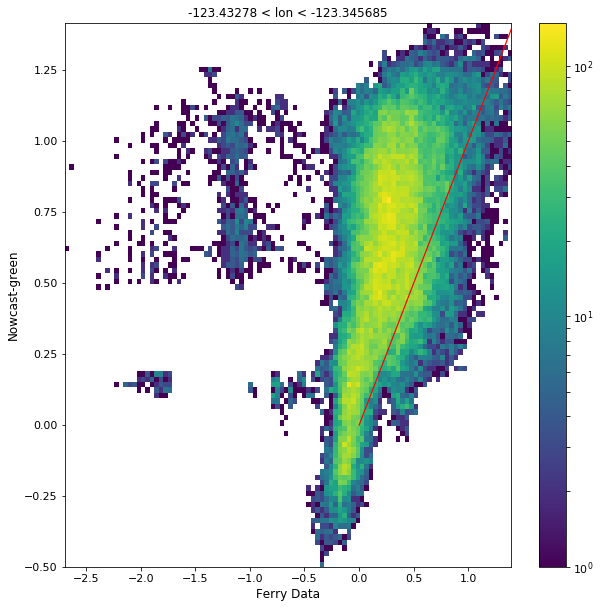

In [137]:
make_log_plot(6)

bias =  0.415965306295
RMSE = 0.588360327774
Willmott = 0.549722376184


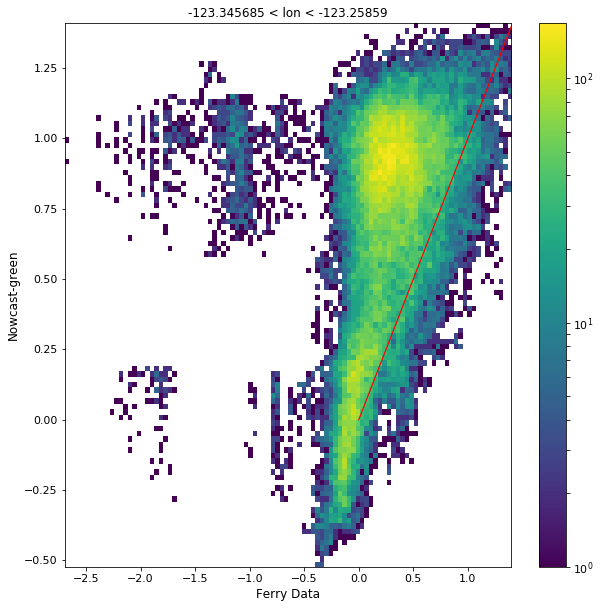

In [138]:
make_log_plot(7)

bias =  0.438642409962
RMSE = 0.607205151614
Willmott = 0.569900510582


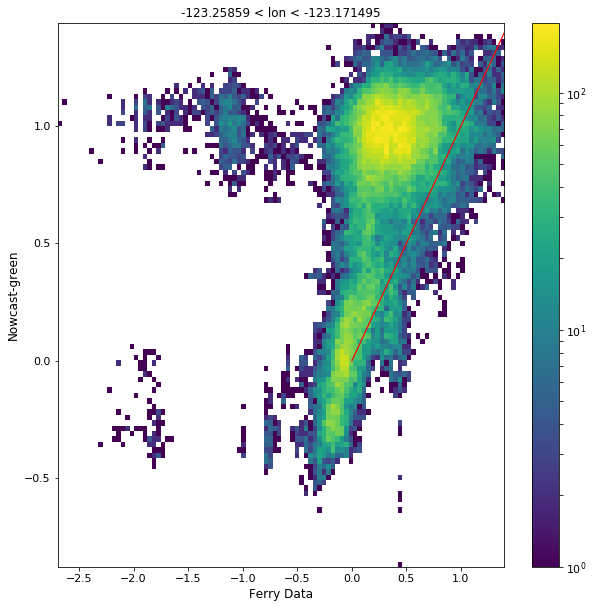

In [139]:
make_log_plot(8)

bias =  0.429892721882
RMSE = 0.605942826148
Willmott = 0.597208825939


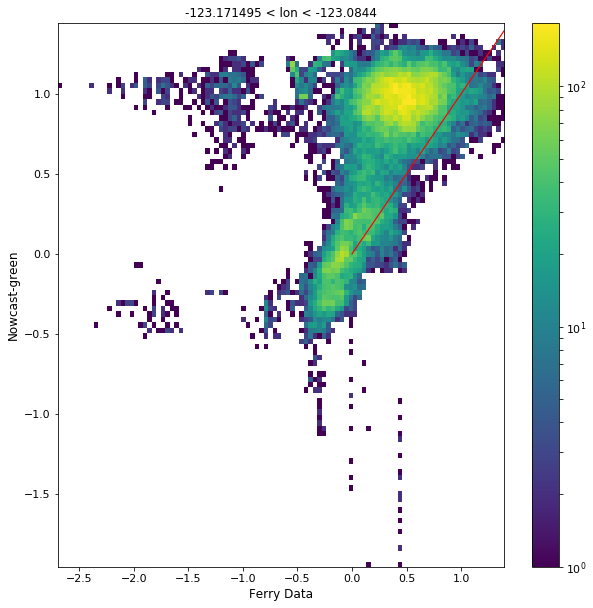

In [140]:
make_log_plot(9)

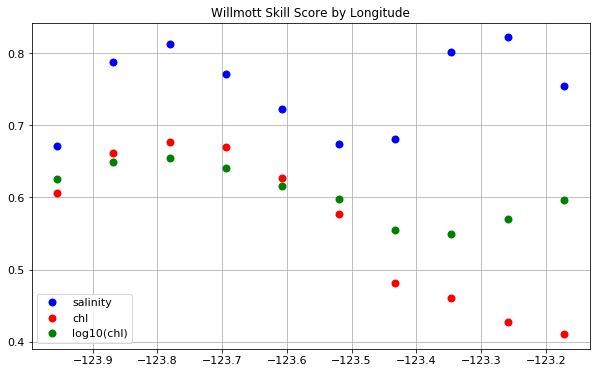

In [141]:
fig, ax = plt.subplots(figsize = (10,6))
ax.plot(bounds[:-1], [0.671300651096, 0.787866750802, 0.813574305729,0.770953337192,0.722419353156,
                      0.673618297025,0.680863445623,0.801244440856,0.822053268011,0.755213496942], 
        'bo', label = 'salinity')
ax.plot(bounds[:-1], [0.606096675921, 0.661740900677, 0.677210364228, 0.669705472444, 
                      0.627474238704, 0.576622408505, 0.481705152104, 0.459957502523, 
                      0.427640182739, 0.410616257023], 'ro', label = 'chl')
ax.plot(bounds[:-1], [0.625474931503, 0.649335129276, 0.654179032163, 0.64124886339, 0.61568651551,
                      0.598083087025, 0.5546428283, 0.549722376184, 0.569900510582, 0.597208825939],
       'go', label = 'log10(chl)')
ax.legend()
ax.grid('on')
ax.set_title('Willmott Skill Score by Longitude');